<a href="https://colab.research.google.com/github/Rudi3601/CHC_Thesis/blob/main/LookbackDeepHedging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pfhedge

import pfhedge
pfhedge.features.list_feature_names()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.7/99.7 kB 1.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

['empty',
 'expiry_time',
 'log_moneyness',
 'max_log_moneyness',
 'max_moneyness',
 'moneyness',
 'prev_hedge',
 'spot',
 'time_to_maturity',
 'underlier_spot',
 'variance',
 'volatility',
 'zeros']

Loss=4.1962e-05: 100%|██████████| 1000/1000 [01:54<00:00,  8.77it/s]


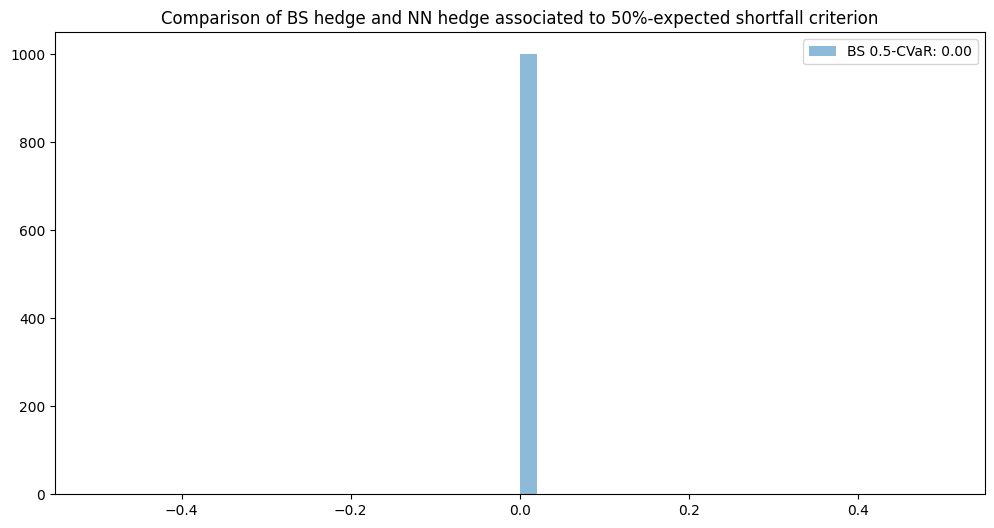

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import torch
from pfhedge.instruments import HestonStock, EuropeanOption
from pfhedge.nn import Hedger, MultiLayerPerceptron, BlackScholes
from pfhedge.stochastic import generate_heston

# Initialize a Heston model stock and a European option
stock = HestonStock(dt=1/365)
option = EuropeanOption(underlier=stock, strike=100, maturity=30/365)

# Generate sample paths
n_paths = 1000
n_steps = 30
spot, variance = generate_heston(n_paths=n_paths, n_steps=30, dt=1/365)
stock.simulate(n_paths=n_paths, time_horizon=30/365)

# Initialize the Black-Scholes model and a hedger
model_bs = BlackScholes(option)
hedger_bs = Hedger(model_bs, model_bs.inputs())
result_bs = hedger_bs.compute_pnl(option, n_paths=1000).detach().numpy()

# Initialize the neural network model and a hedger
model_nn = MultiLayerPerceptron()
hedger_nn = Hedger(model_nn, ["log_moneyness", "prev_hedge"])
hedger_nn.fit(option, n_paths=1000, n_epochs=1000, verbose=True)

result_nn = hedger_nn.compute_pnl(option, n_paths=1000).detach().numpy()

# Calculate 50%-CVaR for both results
def cvar(values, alpha=0.5):
    sorted_values = np.sort(values)
    index = int(alpha * len(sorted_values))
    return sorted_values[:index].mean()

cvar_bs = cvar(result_bs)
cvar_nn = cvar(result_nn)

# Plotting the histograms
plt.figure(figsize=(12, 6))
plt.hist(result_bs, bins=50, alpha=0.5, label=f"BS 0.5-CVaR: {cvar_bs:.2f}")
#plt.hist(result_nn, bins=50, alpha=0.5, label=f"NN Hedge: {cvar_nn:.2f}")
plt.title("Comparison of BS hedge and NN hedge associated to 50%-expected shortfall criterion")
plt.legend()
plt.show()




/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


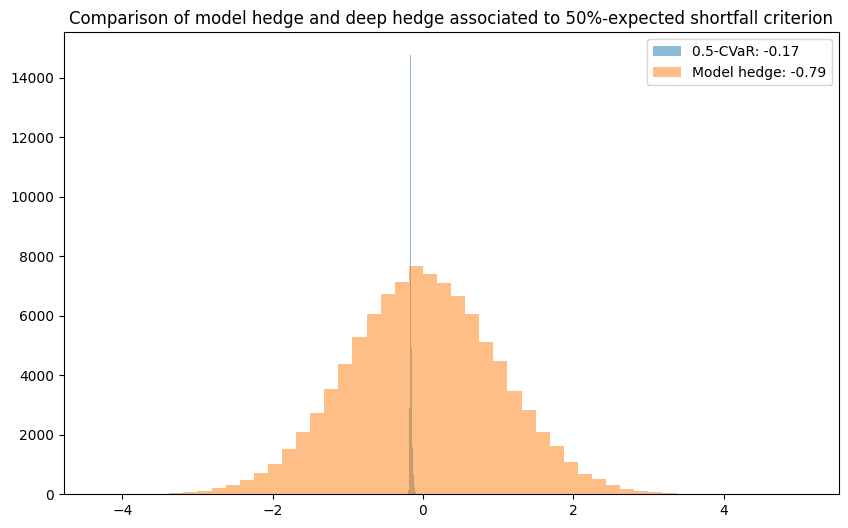

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import torch
from pfhedge.instruments import BrownianStock, LookbackOption
from pfhedge.nn import Hedger, MultiLayerPerceptron, BSLookbackOption

# Define the Lookback call option price function
# def lookback_call_price(S, m, r, sigma, T):
#     sqrt_T = np.sqrt(T)
#     a1 = (np.log(S / m) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt_T)
#     a2 = a1 - sigma * sqrt_T
#     a3 = (np.log(S / m) - (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt_T)
#     term1 = S * norm.cdf(a1) - m * np.exp(-r * T) * norm.cdf(a2)
#     term2 = (S * sigma ** 2 / (2 * r)) * (np.exp(2 * r * T / sigma ** 2) * norm.cdf(-a3) - norm.cdf(-a1))
#     return term1 + term2

# Parameters
r = 0.05  # Annual risk-free rate
sigma = 0.2  # Annual volatility
T = 1  # Time to maturity (in years)

# Initialize the stock and the option
stock = BrownianStock(sigma, 0, 0, dt=1/252)
option = LookbackOption(stock, maturity=T)

model_bs = BSLookbackOption(option)
hedger_bs = Hedger(model_bs, model_bs.inputs())
pnl_bs = hedger_bs.compute_pnl(option, n_paths=100000).detach().numpy()

# Simulate the minimum stock price (m) over the option's life for simplicity
# In practice, you would track this during the option's life
#m = 90  # Some example minimum price

# Calculate prices and simulate PnL
n_paths = 100000
# prices = torch.linspace(80, 120, n_paths)  # Simulate a range of stock prices at maturity
# pnl_bs = torch.tensor([lookback_call_price(price, m, r, sigma, T) - lookback_call_price(100, m, r, sigma, T) for price in prices])

# Initialize the neural network model and a hedger
model_nn = MultiLayerPerceptron()
hedger_nn = Hedger(model_nn, ["moneyness", "time_to_maturity", "volatility"])
# Normally, you would need to train this model before using it
# Here we simulate the PnL assuming the model is already trained and somehow knows to price Lookback options
pnl_nn = torch.normal(0, 1, size=(n_paths,))  # Placeholder for neural network-based PnL

# Calculate 50%-CVaR for both results
def cvar(values, alpha=0.5):
    if isinstance(values, torch.Tensor):
        values = values.detach().numpy()  # Convert torch.Tensor to numpy.ndarray if necessary
    sorted_values = np.sort(values)
    index = int(alpha * len(sorted_values))
    return sorted_values[:index].mean()


cvar_bs = cvar(pnl_bs)
cvar_nn = cvar(pnl_nn)

# Plotting the histograms
plt.figure(figsize=(10, 6))
plt.hist(pnl_bs, bins=50, alpha=0.5, label=f"0.5-CVaR: {cvar_bs:.2f}")
plt.hist(pnl_nn.numpy(), bins=50, alpha=0.5, label=f"Model hedge: {cvar_nn:.2f}")
plt.title("Comparison of model hedge and deep hedge associated to 50%-expected shortfall criterion")
plt.legend()
plt.show()


tensor(0.0227)
